In [1]:
from naslib.utils.io import read_json
from pathlib import Path 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.axes import Axes

In [2]:
sns.set_style("white")
rcParams['axes.titlepad'] = 15
rcParams['font.size'] = 10

In [3]:
datasets = ["CIFAR10" , "CIFAR100", "ImageNet16-120"]
home = Path.home() / "Desktop/Experiments"

def get_label_and_path(dataset): 
    if "CIFAR" in dataset:
        dataset = dataset.lower()
    exp_0 = home/"acq_search=mutation/nasbench201" / dataset / "acq=its/num_to_mutate=2/num_init=10/bananas__ensemble_mlp__gaussian__num_quantiles=10"
    exp_1 = home/"acq_search=mutation/nasbench201" / dataset  / "acq=its/num_to_mutate=2/num_init=10/bananas__ensemble_mlp__CP_split__train_cal_split=05__num_quantiles=10"
    exp_2 = home/"acq_search=mutation/nasbench201" / dataset  / "acq=its/num_to_mutate=2/num_init=10/bananas__ensemble_mlp__CP_cv__train_cal_split=3__num_quantiles=10"
    exp_3 = home/"acq_search=mutation/nasbench201" / dataset  / "acq=its/num_to_mutate=2/num_init=10/bananas__ensemble_mlp__CP_bootstrap__num_ensemble=5__num_quantiles=10_absresidual"
    exp_4 = home/"acq_search=mutation/nasbench201" / dataset  / "acq=its/num_to_mutate=2/num_init=10/bananas__quantile__CP_split__train_cal_split=05__num_quantiles=10"
    exp_5 = home/"acq_search=mutation/nasbench201" / dataset  / "acq=ei/num_to_mutate=2/num_init=10/bananas__quantile__CP_cv__train_cal_split=3__num_quantiles=10"

    label_and_path = {
        "BANANAS": exp_0,
        "SCP Ensemble": exp_1,
        "CrossVal-CP Ensemble": exp_2,
        "Bootstrap-CP Ensemble": exp_3,
        "SCP Quantile": exp_4,
        "CrossVal-CP Quantile": exp_5,
    }
    return label_and_path

In [4]:
QUERY_VAL_ACC = "valid_acc"
QUERY_CAL_ERR = "calibration_score" 
LOG_FILENAME = "errors.json"

def collect_json_info_all_seeds(folder: Path, filename: str = LOG_FILENAME, query_key: str = QUERY_CAL_ERR):
    matches = list(folder.rglob(pattern=f"./seed=*"))

    scores={}
    for p in matches:
        scores[p.name] = read_json(p / filename)[query_key]
    df = pd.DataFrame(scores)
    df.index += 1   # python indexing starts from 0
    df.index.name = "epochs"
    return df.sort_index(axis=1)

### Validation accuracy and RMSCE per epoch

In [5]:
def plot_json_single_experiment(path: Path, ax: Axes, label: str | None, query_key: str, ylabel: str, start_epoch=0, dahses = None):
    df_wide = collect_json_info_all_seeds(folder=path, query_key=query_key)     
    mean = df_wide.iloc[-1, :].mean()
    std = df_wide.iloc[-1, :].std()

    df_wide = df_wide.reset_index()    
    df_wide = df_wide[df_wide["epochs"] >= start_epoch]
    df_long = pd.melt(df_wide, id_vars='epochs')
    legend = None if label is None else "auto"

    label = f"{label}:  mean={round(mean, 3)}, std={round(std, 4)}"
    sns.lineplot(x="epochs", data=df_long, y="value", err_style="band", errorbar="sd", label=label, ax=ax, legend=legend, alpha=0.8, dashes=dahses)
    ax.set_xlabel("epochs")
    ax.set_ylabel(ylabel=ylabel)
    ax.tick_params(labelbottom=True)
    return ax

In [6]:
color_set = [
    "#377EB8",  # blue
    "#4DAF4A",  # green
    "#FF7F00",  # orange
    "#984EA3",  # purple
    "#E41A1C",  # red
  #  "#FFD92F",  # yellow
 #   "#00CED1",  # cyan/turquois
]

# Set as default cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_set)

In [7]:
# fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(8, 5))
# start_epoch = 10
# label_and_path = get_label_and_path(dataset="cifar10")
# for label, path in label_and_path.items():
#     plot_json_single_experiment(path=path, ax=axes, label=label, query_key=QUERY_VAL_ACC, ylabel="validation accuracy", start_epoch=start_epoch)   
#     axes.legend(loc="lower right")

#     axes.set_title("CIFAR10", y=0, pad=-55, verticalalignment="top", fontsize=12)

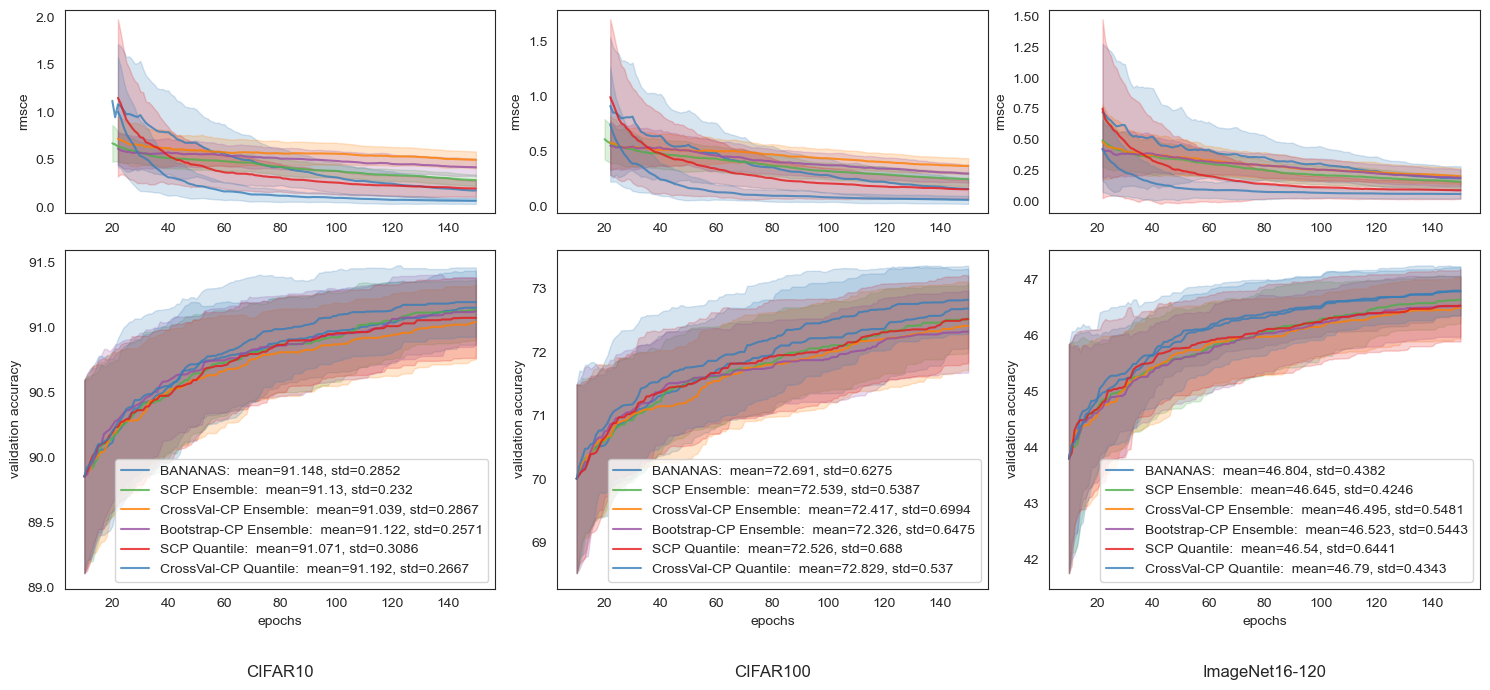

In [8]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 7),sharex=True, gridspec_kw={"height_ratios" : [1.5, 2.5]})
start_epoch = 10

for i, dataset in enumerate(datasets):
    label_and_path = get_label_and_path(dataset=dataset)
    for label, path in label_and_path.items():
        plot_json_single_experiment(path=path, ax=axes[0, i], label=None, query_key=QUERY_CAL_ERR, ylabel="rmsce", start_epoch=start_epoch)
        plot_json_single_experiment(path=path, ax=axes[1, i], label=label, query_key=QUERY_VAL_ACC, ylabel="validation accuracy", start_epoch=start_epoch)
        axes[1, i].legend(loc="lower right")
        axes[1, i].set_title(dataset, y=0, pad=-55, verticalalignment="top", fontsize=12)
plt.tight_layout()

#### Prediction Errors for Ensemble Predictor

In [9]:
import pickle
import numpy as np
from naslib.optimizers.bananas.calibration_utils import ConditionalEstimation

def get_ensmeble_mlp_pred_abs_errors(path):
    with open(path, "rb") as f:
        _, obs_and_dist = pickle.load(f)
        obs_and_dist_unpacked = list(zip(*obs_and_dist))
        y_true = list(obs_and_dist_unpacked[0])
        y_pred = [np.mean(item.point_prediction) if isinstance(item, ConditionalEstimation) else np.nan for item in obs_and_dist_unpacked[1]]
        return  abs(np.array(y_pred) - np.array(y_true))
    
def collect_preds_all_seeds(folder: Path):
    matches = list(folder.rglob(pattern=f"./seed=*"))
    errors ={}
    for p in matches:
        errors[p.name] = get_ensmeble_mlp_pred_abs_errors(path=p / "search_log.pt")
    df = pd.DataFrame(errors)
    df.index += 1   # python indexing starts from 0
    df.index.name = "epochs"
    return df.sort_index(axis=1)


def plot_preds_single_experiment(path: Path, ax: Axes, label: str | None, ylabel: str, start_epoch=0, smooth_window=1):
    df_wide = collect_preds_all_seeds(folder=path)
    mean = np.nanmean(df_wide.values)
    std = np.nanstd(df_wide.values)

    df_wide = df_wide.reset_index()    
    df_wide = df_wide[df_wide["epochs"] >= start_epoch].rolling(10).mean()
    df_long = pd.melt(df_wide, id_vars='epochs')
    legend = None if label is None else "auto"

    label = f"{label}: mean={round(mean, 3)}, std={round(std, 4)}"
    sns.lineplot(x="epochs", data=df_long, y="value", err_style="band", errorbar="sd", label=label, ax=ax, legend=legend, alpha=0.8)
    ax.set_xlabel("epochs")
    ax.set_ylabel(ylabel=ylabel)
    ax.tick_params(labelbottom=True)
    return ax

TypeError: unsupported operand type(s) for /: 'dict' and 'int'

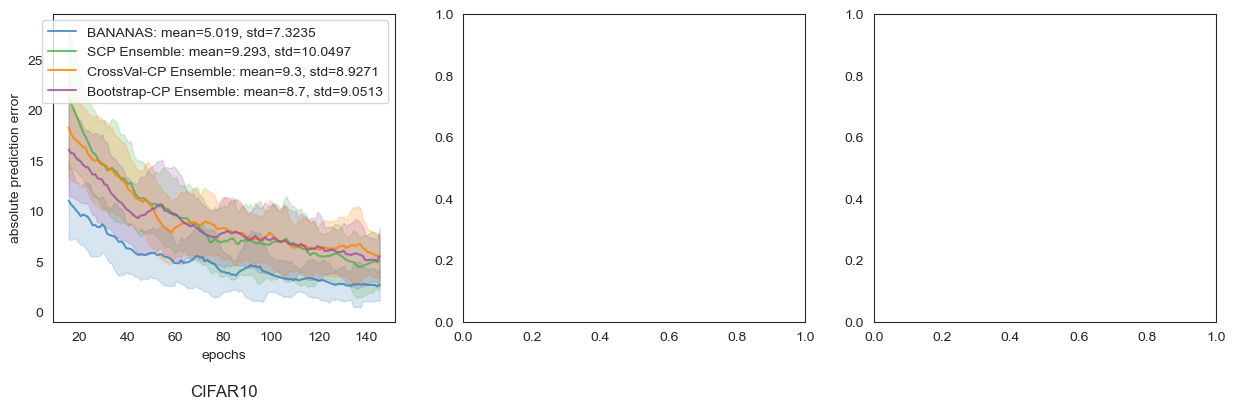

In [10]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
start_epoch = 0

for i, dataset in enumerate(datasets):
    label_and_path = get_label_and_path(dataset=dataset)
    for label, path in label_and_path.items():
        plot_preds_single_experiment(path=path, ax=axes[i], label=label, ylabel="absolute prediction error",  start_epoch=start_epoch)
        axes[i].set_title(dataset, y=0, pad=-45, verticalalignment="top", fontsize=12)
plt.tight_layout()

### Correlation

In [11]:
corr_outputs = {}
for i, dataset in enumerate(datasets):
    label_and_path = get_label_and_path(dataset=dataset)
    for label, path in label_and_path.items():
        corr_outputs.setdefault(label, pd.DataFrame())
         
        series = collect_json_info_all_seeds(folder=path, query_key=QUERY_VAL_ACC).iloc[-1, :]
        df = corr_outputs[label]
        df[dataset] = series
        corr_outputs[label] = df

/var/folders/tm/j0pqlf0d6tq4wff5vgg58dsw0000gn/T/ipykernel_4807/3808227638.py:4: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(wspace=0.45, hspace=0.3)


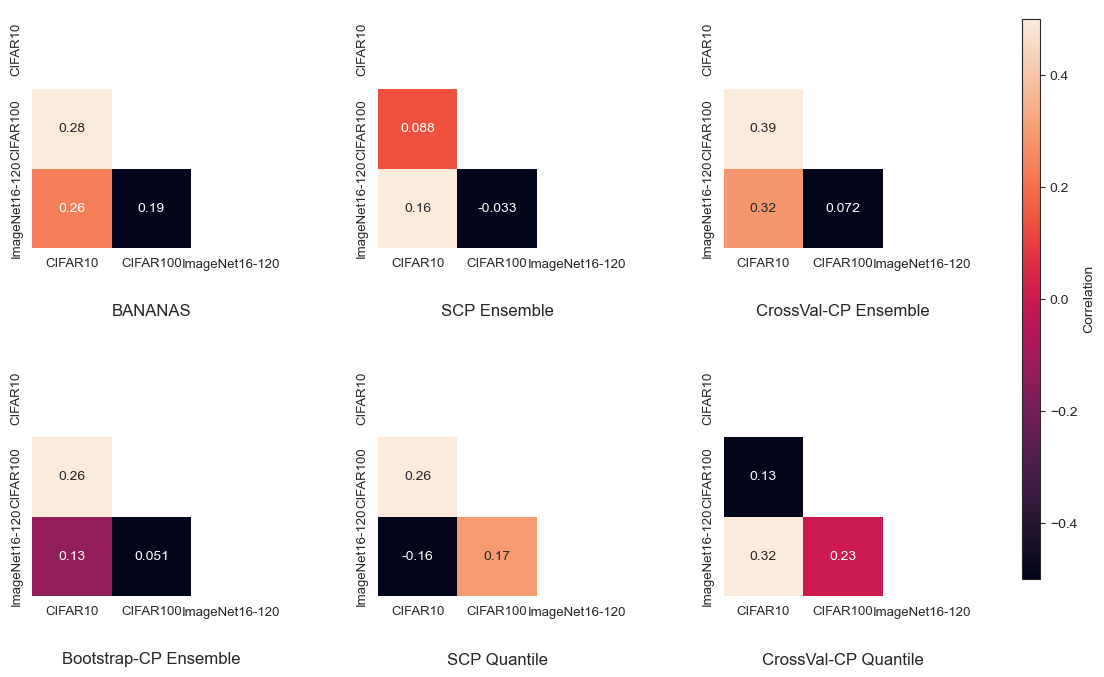

In [12]:
import seaborn as sns

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 8), constrained_layout=True)
fig.subplots_adjust(wspace=0.45, hspace=0.3)

corr_matrices = []
for i, (name, data) in enumerate(corr_outputs.items()):
    corrlation = data.corr()
    corr_matrices.append(corrlation)

    row_idx = i // 3
    col_idx = i % 3
    ax = axes[row_idx, col_idx]
    mask = np.triu(np.ones_like(corrlation, dtype=bool))
    sns.heatmap(corrlation, annot=True, ax=ax, square=True, cbar=False, mask=mask)
    ax.set_title(name, y=0, pad=-40, verticalalignment="top", fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=9.5)  # X-axis: slanted or horizontal
    ax.set_yticklabels(ax.get_yticklabels(), rotation=90, va='center', fontsize=9.5)  # Y-axis: vertical


# add color bar
cbar_ax = fig.add_axes([0.95, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
sns.heatmap(data.corr(), cbar_ax=cbar_ax, cbar=True)
cbar_ax.clear()  # remove the dummy heatmap
cb = fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=-0.5, vmax=0.5)), cax=cbar_ax)
cb.set_label('Correlation')


In [ ]:
# corr_outputs = {}
# for i, dataset in enumerate(datasets):
#     label_and_path = get_label_and_path(dataset=dataset)
#     for label, path in label_and_path.items():
#         series = collect_json_info_all_seeds(folder=path, query_key=QUERY_VAL_ACC).iloc[-1, :]
#         corr_outputs[f"{dataset}_{label}"] = series

# corr_df = pd.concat(corr_outputs, axis=1)

In [ ]:
from matplotlib import cm
from matplotlib.colors import ListedColormap
import numpy as np

def transparent_cmap(cmap_name="coolwarm", alpha=0.6):
    base = cm.get_cmap(cmap_name)
    colors = base(np.linspace(0, 1, 256))
    colors[:, -1] = alpha  # set the alpha channel
    return ListedColormap(colors)


In [ ]:
# fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(15, 10), constrained_layout=True)
# mask = np.triu(np.ones_like(corr_df.corr(), dtype=bool))
# norm = plt.Normalize(vmin=-0.3, vmax=0.3)
# cmap =  transparent_cmap('RdBu_r', alpha=0.9)	
# sns.heatmap(corr_df.corr(), cbar=False,  annot=True, square=True, mask=mask, norm=norm, cmap=cmap, annot_kws={"size": 9})

# cbar_ax = fig.add_axes([0.8, 0.3, 0.02, 0.6])  # [left, bottom, width, height]
# sns.heatmap(corr_df.corr(), cbar_ax=cbar_ax, cbar=True)
# cbar_ax.clear()  # remove the dummy heatmap
# cb = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)

In [ ]:
corr_outputs = {}
for i, dataset in enumerate(datasets):
    label_and_path = get_label_and_path(dataset=dataset)
    tmp = {}
    for label, path in label_and_path.items():
        series = collect_json_info_all_seeds(folder=path, query_key=QUERY_VAL_ACC).iloc[-1, :]
        tmp[label] = series
    corr_outputs[dataset] = pd.concat(tmp, axis=1)

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5), constrained_layout=True)


cmap =  transparent_cmap('coolwarm', alpha=0.9)	
norm = plt.Normalize(vmin=-0.4, vmax=0.4) 
for i, (dataset, data) in enumerate(corr_outputs.items()):
    corr_df  = data.corr()
    mask = np.triu(np.ones_like(corr_df, dtype=bool))
    ax = axes[i]
    sns.heatmap(corr_df, ax=ax, cbar=False,  annot=True, square=True, mask=mask, cmap=cmap, annot_kws={"size": 9})
    ax.set_title(dataset, x=0.4, y=0, pad=-110, verticalalignment="top", fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')  # X-axis
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)       

cbar_ax = fig.add_axes([1, 0.3, 0.01, 0.6])  # [left, bottom, width, height]
sns.heatmap(corr_df, cbar_ax=cbar_ax, cbar=True)
cbar_ax.clear()  # remove the dummy heatmap
cb = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)

### Summary Table

In [ ]:
dfs = {}
for i, dataset in enumerate(datasets):
    label_and_path = get_label_and_path(dataset=dataset)
    df = pd.DataFrame(index=label_and_path.keys())
    for label, path in label_and_path.items():
        val_acc = collect_json_info_all_seeds(folder=path, query_key=QUERY_VAL_ACC).iloc[-1,:]
        cal_err = collect_json_info_all_seeds(folder=path, query_key=QUERY_CAL_ERR).iloc[-1,:]
        df.loc[label, "val. acc"] = f"{round(val_acc.mean(), 3)} ({round(val_acc.std(), 4)})"
        df.loc[label, "RMSCE"] = f"{round(cal_err.mean(), 3)} ({round(cal_err.std(), 4)})"
        dfs[dataset] =  df    

In [ ]:
pd.concat(dfs, axis=1)

### Standard Deviation of Estimated Std

In [ ]:
import pickle
import numpy as np
from naslib.optimizers.bananas.distribution import GaussianDist, PointwiseInterpolatedDist
from naslib.optimizers.bananas.calibration_utils import ConditionalEstimation

def get_distribution_std(path):
    with open(path, "rb") as f:
        _, obs_and_dist = pickle.load(f)
        obs_and_dist_unpacked = list(zip(*obs_and_dist))
        stds = []
        for item in obs_and_dist_unpacked[1]:
            if isinstance(item, ConditionalEstimation):
                if isinstance(item.distribution, GaussianDist):
                    std = item.distribution.dist.std()
                elif isinstance(item.distribution, PointwiseInterpolatedDist):
                    std = item.distribution.std()
            else:
                std = np.nan
            stds.append(std)
        return pd.Series(stds)
    

def collect_dist_stds_all_seeds(folder: Path):
    matches = list(folder.rglob(pattern=f"./seed=*"))
    stds ={}
    for p in matches:
        stds[p.name] = get_distribution_std(path=p / "search_log.pt")
    df = pd.DataFrame(stds)
    df.index += 1   # python indexing starts from 0
    df.index.name = "epochs"
    return df.sort_index(axis=1)

In [ ]:
all_data = {}

for i, dataset in enumerate(datasets):
    label_and_path = get_label_and_path(dataset=dataset)

    dfs_stds = {}
    for label, path in label_and_path.items():
        dfs_stds[label] = collect_dist_stds_all_seeds(folder=path)
    all_data[dataset] = dfs_stds

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(15, 22) )
epochs = [20, 50, 80, 110, 140]


for i, dataset in enumerate(datasets):
    dfs_stds =  all_data[dataset]
    for j, epoch in enumerate(epochs):
        dfs_tmp = {}
        for label, df in dfs_stds.items():
            dfs_tmp[label] = df.loc[epoch + 1]

        df_ =  pd.concat(dfs_tmp, axis=1)
        ax = axes[j, i]
        if j > 0:
            ax.sharex(axes[0, i])
        
        sns.boxplot(df_, ax=ax, linecolor="#137", linewidth=.7,  boxprops={"facecolor": (.3, .5, .7)}, orient="h", medianprops={"color": "black", "linewidth": 0.7})
        for label in ax.get_yticklabels():
           label.set_rotation(45)
           label.set_fontsize(10)
        ax.tick_params(labelbottom=True) 
        ax.set_title(f"distribution std ({epoch}-th epoch)", y=0, pad=-20, verticalalignment="top", fontsize=10)
    ax.set_xlabel(dataset, labelpad=35)

plt.tight_layout()